--- 开始参数扫描 ---
参数: N=5120, K1=-0.5, K2=1, t_max=100.0
扫描范围:
  X轴 (p_s): 15 步, 从 0.05 到 0.95
  Y轴 (r1): 20 步, 从 0.010 到 3.000
总计模拟次数: 300
警告: 这可能需要非常长的时间...


速率 (Y轴): 100%|██████████| 20/20 [10:15<00:00, 30.75s/it]

--- 扫描完成 ---


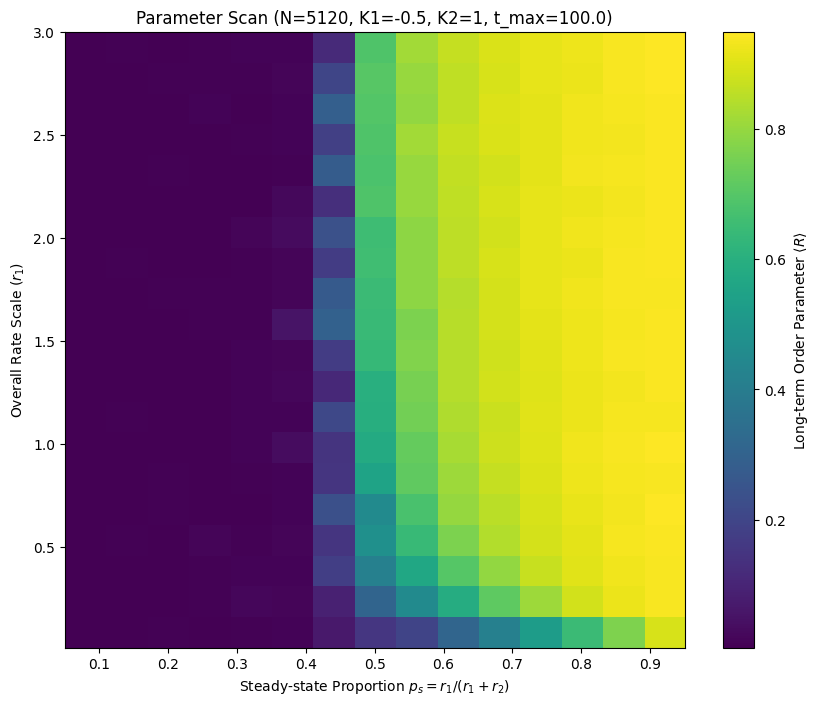

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from tqdm import tqdm  # 导入tqdm库用于显示进度条

# ---------- 您提供的所有工具函数 ----------
# (此处粘贴您提供的所有函数：sample_lorentzian, 
#  heun_step_thetas, simulate_microscopic_init, 
#  chemical_reaction_tau_leaping, simulate_microscopic)
# ---------- Utility functions ----------
def sample_lorentzian(gamma, size):
    return gamma * np.random.standard_cauchy(size=size)

def heun_step_thetas(thetas, omegas, Ks, dt):
    Z = np.mean(np.exp(1j * thetas))
    R = np.abs(Z)
    phi = np.angle(Z)
    theta_dot = omegas + Ks * R * np.sin(phi - thetas)
    thetas_pred = thetas + dt * theta_dot
    Z_pred = np.mean(np.exp(1j * thetas_pred))
    R_pred = np.abs(Z_pred)
    phi_pred = np.angle(Z_pred)
    theta_dot_pred = omegas + Ks * R_pred * np.sin(phi_pred - thetas_pred)
    thetas_new = thetas + dt * 0.5 * (theta_dot + theta_dot_pred)
    return thetas_new

def simulate_microscopic_init(N, K1, K2, p, gamma, seed=None):
    if seed is not None:
        np.random.seed(seed)
    types = np.random.rand(N) < p
    Ks = np.where(types, K2, K1)
    omegas = sample_lorentzian(gamma, N)
    thetas = 2 * pi * np.random.rand(N)
    z1_0 = np.mean(np.exp(1j * thetas[Ks == K1])) if np.any(Ks == K1) else 0.0
    z2_0 = np.mean(np.exp(1j * thetas[Ks == K2])) if np.any(Ks == K2) else 0.0
    z1_2_0= np.mean(np.exp(1j * 2 * thetas[Ks == K1])) if np.any(Ks == K1) else 0.0
    z2_2_0= np.mean(np.exp(1j * 2 * thetas[Ks == K1])) if np.any(Ks == K1) else 0.0
    z1_3_0= np.mean(np.exp(1j * 3 * thetas[Ks == K1])) if np.any(Ks == K1) else 0.0
    z2_3_0= np.mean(np.exp(1j * 3 * thetas[Ks == K1])) if np.any(Ks == K1) else 0.0
    kappa1_init = z1_2_0 - z1_0**2
    kappa2_init = z2_2_0 - z2_0**2
    varkappa1_init = (z1_3_0 - 3*z1_2_0*z1_0 + 2*z1_0**3)/2
    varkappa2_init = (z2_3_0 - 3*z2_2_0*z2_0 + 2*z2_0**3)/2
    return thetas, omegas, Ks, z1_0, z2_0, kappa1_init, kappa2_init, varkappa1_init, varkappa2_init

def chemical_reaction_tau_leaping(types, Ks, K1, K2, r1, r2, dt):
    """
    使用tau-leaping算法处理化学反应
    types: 当前类型数组 (True=正/K2, False=负/K1)
    Ks: 耦合强度数组
    r1, r2: 反应速率
    dt: 时间步长
    返回: 更新后的types和Ks
    """
    N = len(types)
    n_positive = np.sum(types)
    n_negative = N - n_positive
    
    # 计算反应事件数（泊松分布）
    n_pos_to_neg = np.random.poisson(r1 * n_positive * dt)
    n_neg_to_pos = np.random.poisson(r2 * n_negative * dt)
    
    # 限制不超过可用个体数
    n_pos_to_neg = min(n_pos_to_neg, n_positive)
    n_neg_to_pos = min(n_neg_to_pos, n_negative)
    
    # 执行转换
    if n_pos_to_neg > 0:
        pos_indices = np.where(types)[0]
        convert_indices = np.random.choice(pos_indices, n_pos_to_neg, replace=False)
        types[convert_indices] = False
        Ks[convert_indices] = K1  # 更新耦合强度
    
    if n_neg_to_pos > 0:
        neg_indices = np.where(~types)[0]
        convert_indices = np.random.choice(neg_indices, n_neg_to_pos, replace=False)
        types[convert_indices] = True
        Ks[convert_indices] = K2  # 更新耦合强度
    
    return types, Ks

def simulate_microscopic(thetas, omegas, Ks, K1, K2, p0, r1, r2, dt, t_max):
    times = np.arange(0, t_max, dt)
    N = len(thetas)
    R_ts = np.zeros_like(times)
    R1_ts = np.zeros_like(times)
    R2_ts = np.zeros_like(times)
    p_ts = np.zeros_like(times)  # 记录p随时间变化
    Z_ts = np.zeros(len(times), dtype=complex)
    
    # 初始化类型数组
    types = (Ks == K2)
    p_ts[0] = np.mean(types)
    
    for i, t in enumerate(times):
        if i > 0:  # 跳过初始时间步
            # 化学反应
            types, Ks = chemical_reaction_tau_leaping(types, Ks, K1, K2, r1, r2, dt)
            p_ts[i] = np.mean(types)
        
        mask1 = (Ks == K1)
        mask2 = (Ks == K2)
        
        Z = np.mean(np.exp(1j * thetas))
        Z1 = np.mean(np.exp(1j * thetas[mask1])) if np.any(mask1) else 0
        Z2 = np.mean(np.exp(1j * thetas[mask2])) if np.any(mask2) else 0
        
        R_ts[i] = np.abs(Z)
        R1_ts[i] = np.abs(Z1)
        R2_ts[i] = np.abs(Z2)
        Z_ts[i] = Z
        
        # Kuramoto动力学
        thetas = heun_step_thetas(thetas, omegas, Ks, dt)
    
    return times, R_ts, R1_ts, R2_ts, Z_ts, p_ts

# ---------- 模拟函数 (您提供的) ----------
def run_simulation():
    """
    同时运行微观与还原模拟。
    还原模型部分现在返回 z1, z2, kappa1, kappa2, varkappa1, varkappa2。
    
    !!! 注意：此函数隐式依赖 *全局* 变量:
    N, K1, K2, p0, gamma, seed, r1, r2, dt, t_max, p_eq
    """
    # --- initialize 微观模拟 ---
    thetas, omegas, Ks, z1_0, z2_0, kappa1_init, kappa2_init, varkappa1_init, varkappa2_init = simulate_microscopic_init(
        N, K1, K2, p0, gamma, seed
    )
    # --- simulate 微观 ---
    times_m, Rm, R1m, R2m, Zm, p_micro = simulate_microscopic(
        thetas, omegas, Ks, K1, K2, p0, r1, r2, dt, t_max
    )
    # --- 返回所有模拟结果 ---
    return {
        # 微观模拟
        'times_m': times_m,
        'Rm': Rm,
        'R1m': R1m,
        'R2m': R2m,
        'Zm': Zm,
        'p_micro': p_micro,
        # 参数信息
        'params': {
            'N': N,
            'K1': K1,
            'K2': K2,
            'p0': p0,
            'gamma': gamma,
            'r1': r1,
            'r2': r2,
            'p_eq': p_eq, # 注意：这里的 p_eq 只是记录，模拟依赖 r1, r2
        },
    }

# ===================================================================
# ================== 主要扫描与绘图程序 ==================
# ===================================================================

if __name__ == '__main__':

    # --- 1. 定义固定的全局参数 ---
    # ⚠️ 警告: N=51200 会非常慢! 
    # 建议测试时使用 N = 2048, t_max = 100.0
    N = 5120
    K1, K2 = -0.5, 1
    gamma = 0.05
    dt = 0.02
    t_max = 100.0
    seed_base = 12345 # 基础随机种子

    # --- 2. 定义扫描参数范围 ---
    P_STEPS = 15  # X轴 (p_s) 的步数
    R_STEPS = 20  # Y轴 (rate_scale) 的步数

    # X轴: 稳态比例 p_s (p_eq)
    p_s_values = np.linspace(0.05, 0.95, P_STEPS)
    
    # Y轴: 整体速率 (我们用 r1 作为代表)
    # 速率太慢 (如0.001), 200s可能不够; 速率太快 (如1.0), 动力学可能不同
    rate_scale_values = np.linspace(0.01, 3, R_STEPS) 

    # --- 3. 初始化结果存储网格 ---
    # R_steady_state[i, j] 对应 (rate_scale_values[i], p_s_values[j])
    R_steady_state = np.zeros((R_STEPS, P_STEPS))

    print(f"--- 开始参数扫描 ---")
    print(f"参数: N={N}, K1={K1}, K2={K2}, t_max={t_max}")
    print(f"扫描范围:")
    print(f"  X轴 (p_s): {P_STEPS} 步, 从 {p_s_values.min():.2f} 到 {p_s_values.max():.2f}")
    print(f"  Y轴 (r1): {R_STEPS} 步, 从 {rate_scale_values.min():.3f} 到 {rate_scale_values.max():.3f}")
    print(f"总计模拟次数: {P_STEPS * R_STEPS}")
    print("警告: 这可能需要非常长的时间...")

    # 设置一个总的随机种子，以确保扫描结果可复现
    np.random.seed(seed_base)

    # --- 4. 执行扫描循环 ---
    # 外循环 (Y轴: 速率)
    for i, rate_scale in enumerate(tqdm(rate_scale_values, desc="速率 (Y轴)")):
        
        # 内循环 (X轴: 比例 p_s)
        for j, p_s_val in enumerate(p_s_values):
            
            # !!! 关键步骤: 修改全局变量 !!!
            # run_simulation() 将读取这些新设置的全局值
            
            r1 = rate_scale
            p_s = p_s_val
            p0 = p_s_val      # 假设系统从稳态比例 p_s 开始
            p_eq = p_s_val    # 用于记录在返回的字典中
            
            # 根据 p_s * r1 = (1 - p_s) * r2 计算 r2
            if p_s < 1.0 - 1e-9: # 避免 p_s = 1 时除以零
                r2 = r1 * p_s / (1 - p_s)  # <--- 这是正确行
            else:
                # 这种情况下 p_s 接近 1，r2 应该非常大
                # 但为了避免除零，您可能需要定义这种情况
                # (不过您的 p_s_values 最大是 0.95, 不会触发)
                r2 = r1 * p_s / (1 - p_s) # 保持一致

            if p_s < 1e-9: # 增加一个 p_s = 0 的保护
                r2 = 0.0
            
            # 为每次模拟设置一个唯一的种子，以减少初始条件的影响
            seed = seed_base + i * P_STEPS + j

            # --- 运行单次模拟 ---
            results = run_simulation()
            
            # --- 提取并处理结果 ---
            Rm = results['Rm']
            
            # 计算长时间后的序参量
            # 我们丢弃前75%的数据作为暂态
            transient_steps = int(len(Rm) * 0.75)
            R_long_term = np.mean(Rm[transient_steps:])
            
            # 存储结果
            R_steady_state[i, j] = R_long_term

    print("--- 扫描完成 ---")

    # --- 5. 可视化结果 ---
    plt.figure(figsize=(10, 8))
    
    # 使用 imshow 绘制热图
    # origin='lower' 使 Y 轴从下到上增加
    # extent 定义坐标轴的范围
    im = plt.imshow(R_steady_state, 
                    aspect='auto', 
                    origin='lower', 
                    extent=[p_s_values.min(), p_s_values.max(), 
                            rate_scale_values.min(), rate_scale_values.max()],
                    cmap='viridis') # 'viridis', 'inferno', 'jet' 都是不错的色图

    plt.colorbar(im, label='Long-term Order Parameter $\\langle R \\rangle$')
    
    # 设置坐标轴和标题
    plt.xlabel('Steady-state Proportion $p_s = r_1 / (r_1 + r_2)$')
    plt.ylabel('Overall Rate Scale ($r_1$)')
    plt.title(f'Parameter Scan (N={N}, K1={K1}, K2={K2}, t_max={t_max})')
    
    plt.show()